This another implementation of a neuronal network estimator to classify MNIST images. It uses more convolutional and pooling layers than the previous version

## Import statements

In [1]:
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Model
from keras.layers import Conv2D, AvgPool2D, Flatten, Activation, Input, Dense, MaxPool2D
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

Using TensorFlow backend.


## Load dataset

In [2]:
data = np.load('./data/preprocessed.npz')
X, y  = data['X'], data['y']
y_cat = to_categorical(y)

X = X.reshape((-1, 28, 28, 1))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=13)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

## Create the model

In [48]:
t_in = Input(shape=(28, 28, 1))

t_conv = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(t_in)
t_pool = MaxPool2D(pool_size=(2, 2))(t_conv)

t_conv2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(t_pool)
t_pool2 = MaxPool2D(pool_size=(2,2))(t_conv2)

t_flat = Flatten()(t_pool2)

# Full connected layers part
t = Dense(units=32, activation='relu', use_bias=True)(t_flat)
t_out = Dense(units=10, activation='softmax', use_bias=True)(t)

model = Model(inputs=[t_in], outputs=[t_out])
model.compile(RMSprop(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
initial_weights = model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                51232     
__________

## Cross-validate the model

In [44]:
def build():
    model.set_weights(initial_weights)
    return model
wrapper = KerasClassifier(build, batch_size=128, epochs=2, verbose=True)
cv = StratifiedKFold(3, shuffle=True, random_state=13)
cv_results = cross_val_score(wrapper, X_train, y_train, scoring='accuracy', cv=cv)
print('Done')

Epoch 1/2
 5120/41998 [==>...........................] - ETA: 49s - loss: 2.4288 - acc: 0.2828

KeyboardInterrupt: 

In [37]:
cv_results

array([0.86087039, 0.11204762, 0.96575864])

In [38]:
print('Accuracy score is {} +- {}'.format(np.mean(cv_results), np.std(cv_results)))

Accuracy score is 0.6462255520079486 +- 0.38014026736938983


## Final prediction on test set

In [49]:
model.set_weights(initial_weights)
history = model.fit(X_train, y_train_cat, batch_size=128, epochs=2, verbose=True)

Epoch 1/2
63000/63000 [==============================] - 88s 1ms/step - loss: 0.5128 - acc: 0.8539
Epoch 2/2
63000/63000 [==============================] - 82s 1ms/step - loss: 0.2286 - acc: 0.9452


In [50]:
print('Accuracy on train set: {}'.format(model.evaluate(X_train, y_train_cat)[1].round(3)))
print('Accuracy on test set: {}'.format(model.evaluate(X_test, y_test_cat)[1].round(3)))

63000/63000 [==============================] - 47s 743us/step
Accuracy on train set: 0.967
7000/7000 [==============================] - 5s 749us/step
Accuracy on test set: 0.963


In [51]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

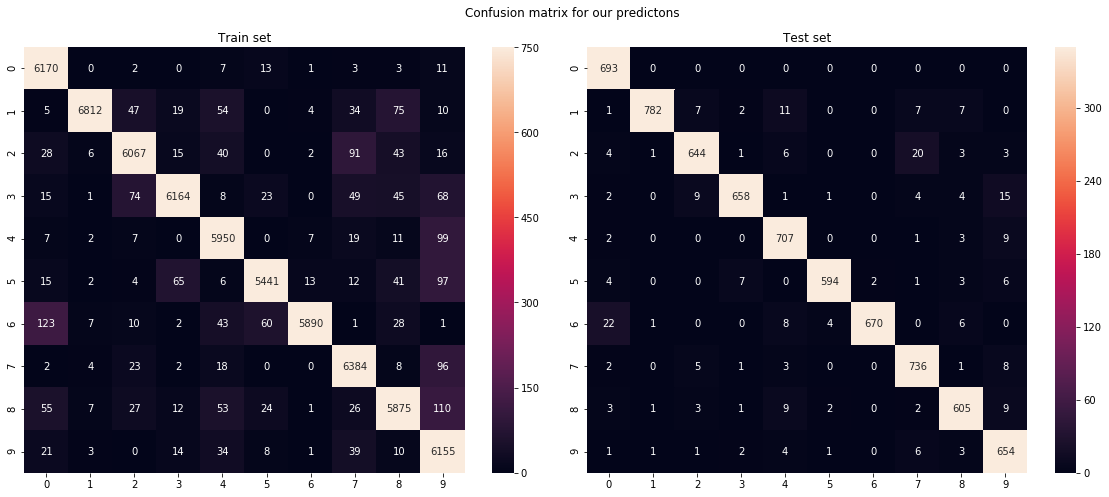

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

plt.sca(ax[0])
sns.heatmap(pd.DataFrame(confusion_matrix(y_train, y_train_pred)), annot=True, fmt='d', vmax=750)
plt.title('Train set')

plt.sca(ax[1])
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred)), annot=True, fmt='d', vmax=350)
plt.title('Test set')

plt.suptitle('Confusion matrix for our predictons')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

## Visualize the inner layers representation

In [54]:
x = X[4:5, :, :, :]

f_conv = K.Function([t_in], [t_conv])
y_conv = f_conv([ x ])[0]

f_pool = K.Function([t_conv], [t_pool])
y_pool = f_pool([ y_conv ])[0]

In [31]:
print(x.shape)
print(y_conv.shape)
print(y_pool.shape)
print(y_activation.shape)

(1, 28, 28, 1)
(1, 26, 26, 32)
(1, 13, 13, 32)
(1, 5, 5, 64)


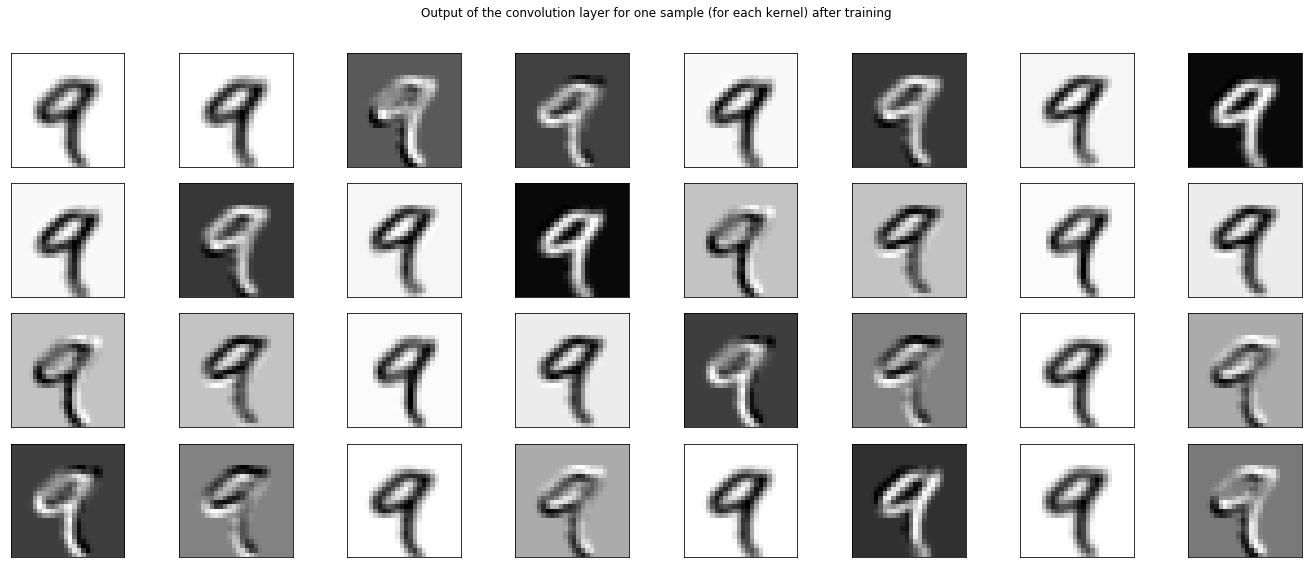

In [32]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_conv[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the convolution layer for one sample (for each kernel) after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

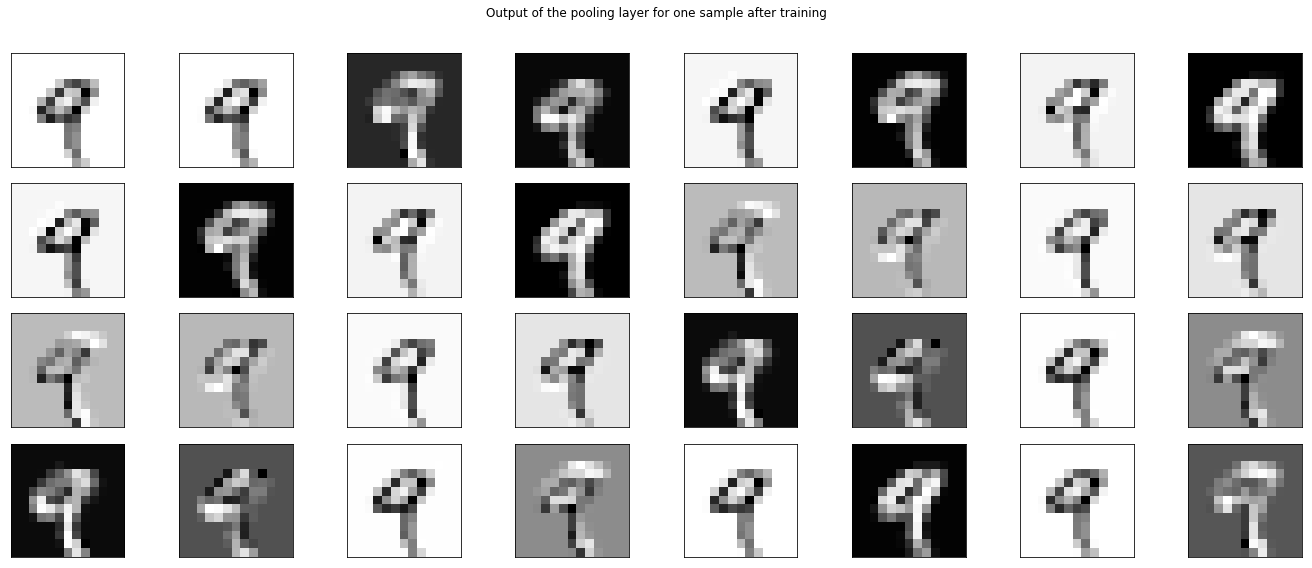

In [33]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_pool[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the pooling layer for one sample after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

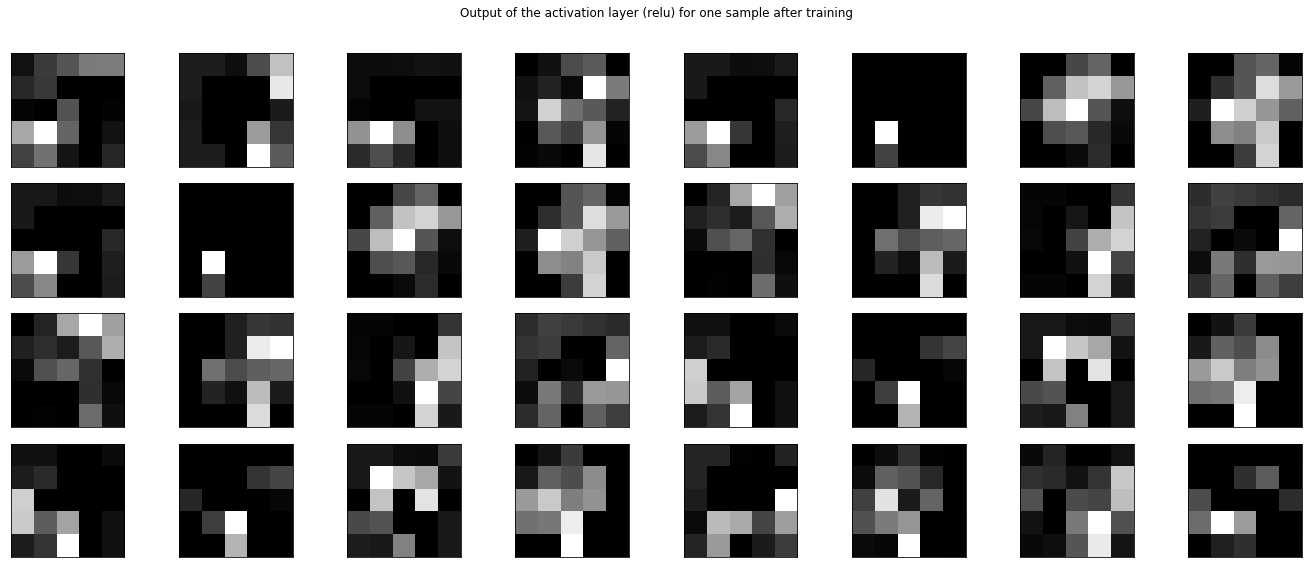

In [34]:
fig, ax = plt.subplots(4, 8, figsize=(19, 8))

for i in range(0, 4):
    for j in range(0, 8):
        plt.sca(ax[i, j])
        plt.imshow(y_activation[0, :, :, i * 4 + j], cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.suptitle('Output of the activation layer (relu) for one sample after training')
plt.tight_layout()
plt.subplots_adjust(top=0.9)